#### Bayes vs Frecuentismo

Bayes:
+ parametros $\Rightarrow p$
+ interpretacion sencilla de IC (intervalo de credibilidad)
+ Subjetivos: suponemos un conocimiento previo (priors)
+ La regularizacion "calza bien" en el framework

Frecuentismo:
+ parametros son un numero
+ Objetivos
+ Hay que "inventar" la regularizacion:
  + penalizacion de $\lambda$
  + modificacion de Likelihood
  
Para los grandes números ambos coinciden

# Modelos Jerárquicos Bayesianos

Tratan de pensar los problemas como parte de un problema más grande

Imaginemos que queremos ver el índice de impacto de una enfermedad (rara)  
1 de cada 10k personas tiene esta enfermedad  

queremos decir cuanto es la proporcion de gente con esta enfermedad en cada partido  

supongamos un pais con 100 partidos  
sabemos cuantas personas tienen la enfermedad

1 partido:
+ N personas
+ k personas con enfermedad
  
Cantidad de personas con enfermedad:
+ frecuentista: $\frac{k}{n}$
  + para encontrar esto maximizamos la likelihood
  + 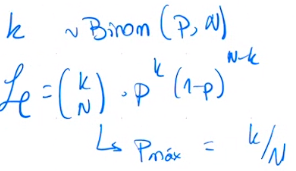
+ bayesiano:
  + $p(\theta | d) \alpha p(\theta)L(d|\theta)$
  + prior $\rightarrow$ MCMC (o la tecnica que quiera) $\rightarrow$ $p(\theta|d)$

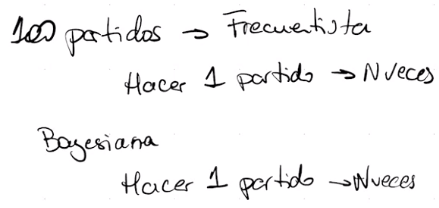


#### Un problema
Si dentro de un partido no hay nadie con la enfermedad, la probabilidad me va a dar 0.

En bayes esto no pasa porque el prior nos salva.

Tengo que tener un prior de la distribucion de $\theta$  
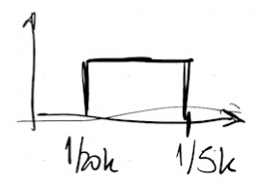

##### ¿ Qué pasa si no supieramos el prior?  
Podria hacer un censo de la enfermedad en los partidos mas grandes y sacar el promedio de la proporcion.  
Esto no está muy bien, ya que estamos viendo informacion actual y la tomamos como previa (prior).  
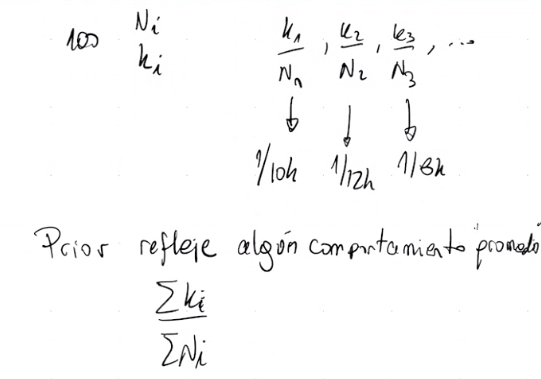  
para resolver esto podriamos hacer esto:  
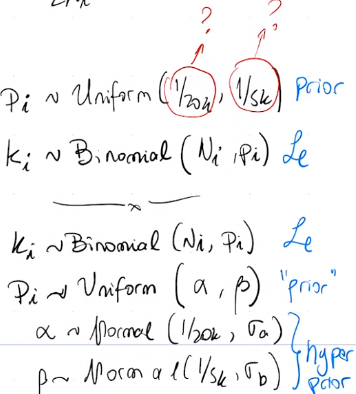  
Como no se cual es el prior, lo miro en la data y, para volver a darle "incertidumbre" con el uso de hyperpriors

### Notebook

In [22]:
import pymc as pm
import arviz as az

In [13]:
import numpy as np
import matplotlib.pyplot as plt

n_partidos = 50

population = np.concatenate((np.ones(n_partidos // 2, dtype=int) * 3_000, np.ones(n_partidos // 2, dtype=int) * 1_000_000))

In [14]:
true_rates = np.random.beta(2, 1998, size = n_partidos)
cases = np.random.binomial(n= population, p=true_rates)

In [15]:
population, cases

(array([   3000,    3000,    3000,    3000,    3000,    3000,    3000,
           3000,    3000,    3000,    3000,    3000,    3000,    3000,
           3000,    3000,    3000,    3000,    3000,    3000,    3000,
           3000,    3000,    3000,    3000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000]),
 array([   8,    4,    1,    2,    2,    1,    1,    0,    2,    0,    4,
           5,    0,    0,    6,   11,    2,    0,    5,    0,    5,    3,
           2,    0,    3,  747,  963,  878,  987, 3997, 1248,  834,  909,
        1953, 1196, 1202, 2171, 3215,  372, 1360, 2042, 1236,  610, 1073,
         944,  564, 1086,  405, 3325, 1117]))

(array([11.,  9., 12.,  6.,  4.,  3.,  1.,  0.,  2.,  2.]),
 array([0.       , 0.0003997, 0.0007994, 0.0011991, 0.0015988, 0.0019985,
        0.0023982, 0.0027979, 0.0031976, 0.0035973, 0.003997 ]),
 <BarContainer object of 10 artists>)

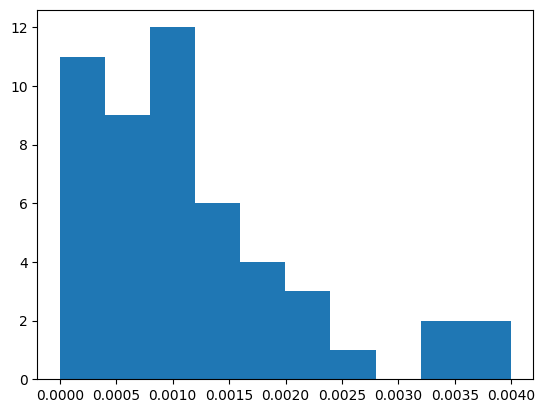

In [16]:
plt.hist(cases/population)

In [20]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y_obs = pm.Binomial('y_obs', n = population, p = theta, observed = cases)
    pooled_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

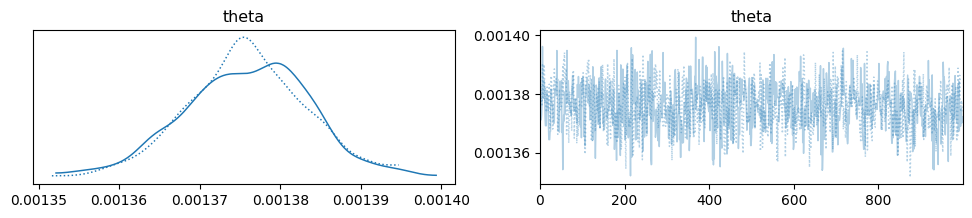

In [23]:
az.plot_trace(pooled_trace)

In [24]:
with pm.Model() as unpooled_model:
    theta = pm.Beta('theta', alpha=1, beta=1, shape= 50) # este es el prior
    y_obs = pm.Binomial('y_obs', n = population, p = theta, observed = cases)
    unpooled_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 237 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

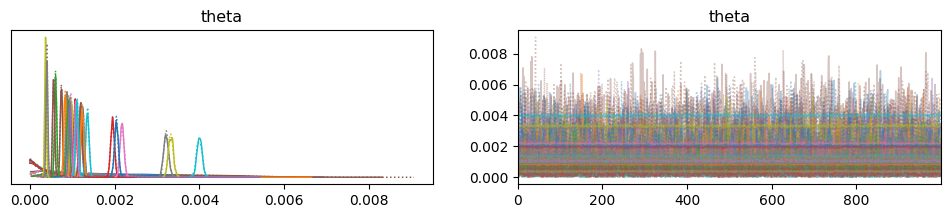

In [25]:
az.plot_trace(unpooled_trace)

hay 50 thetas diferentes

In [26]:
unpooled_means = unpooled_trace.posterior["theta"].mean(dim= ["chain", "draw"])

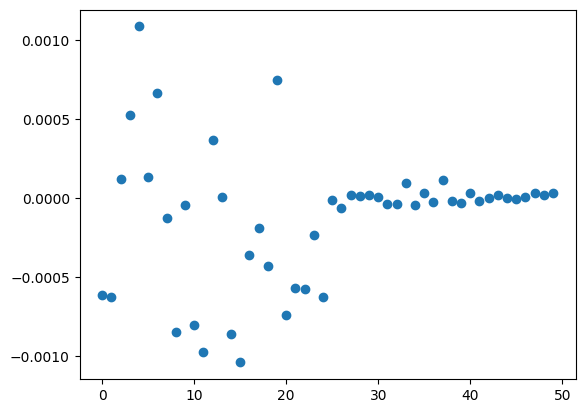

In [27]:
plt.plot(true_rates - unpooled_means, "o")

In [29]:
with pm.Model() as hierarchical_model:
    alpha = pm.Gamma("alpha", 1, 1)
    beta = pm.Gamma("beta", 1, 1)
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape= 50) # como no se el prior
    y_obs = pm.Binomial('y_obs', n = population, p = theta, observed = cases)
    hierarchical_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, theta]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Output()

In [ ]:
az.plot_trace(hierarchical_trace)
plt.gcf().tight_layout()

In [ ]:
hierarchical_means = hierarchical_trace.posterior["theta"].mean(dim= ["chain", "draw"])
plt.plot(hierarchical_means - true_rates, "o", label = "H")
plt.plot(unpooled_means - true_rates, "o", label = "U")
plt.legend()


Vemos que el H trajo mas hacia adentro a los casos del U

Capitulo 13 de McElreath  
Hacer el ejemplo con pymc